In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,ConfusionMatrixDisplay, \
                        precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
import pickle
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    

C:\Users\Sheela Sai kumar\anaconda3\envs\financePro\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Nodes and edges

In [6]:
df_classes = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [7]:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [8]:
df_classes.shape

(203769, 2)

In [9]:
df_classes['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64


The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.

In [10]:
df_edgelist = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_edgelist.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [11]:
df_edgelist.shape

(234355, 2)

In [12]:
df_edgelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB


### Features

In [13]:
df_features = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_features.csv',header = None )
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [14]:
df_features.shape

(203769, 167)

In [15]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, 0 to 166
dtypes: float64(165), int64(2)
memory usage: 259.6 MB


## EDA

In [16]:
df_feat_missing = df_features.isna().sum().reset_index().rename(columns = {0:'no.of missing values'})
df_feat_missing.head()

,index,no.of missing values
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [17]:
df_feat_missing[df_feat_missing['no.of missing values']!=0].count()

index                   0
no.of missing values    0
dtype: int64

In [18]:
df_features[1].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int64)

There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks. Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

In [19]:
# based on the given data
col = ['txid','timestamp'] + ["trans_feat_{0}".format(i) for i in range(1,94)] + ['aggre_feat_{}'.format(j) for j in range(1,73)]
print('sample:',col[:5])
print('No.of columns :', len(col))

sample: ['txid', 'timestamp', 'trans_feat_1', 'trans_feat_2', 'trans_feat_3']
No.of columns : 167


In [20]:
df_features.columns = col
df_features.head()

,txid,timestamp,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,aggre_feat_63,aggre_feat_64,aggre_feat_65,aggre_feat_66,aggre_feat_67,aggre_feat_68,aggre_feat_69,aggre_feat_70,aggre_feat_71,aggre_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


Text(0.5, 1.0, 'No.of transactions in different time stamp')

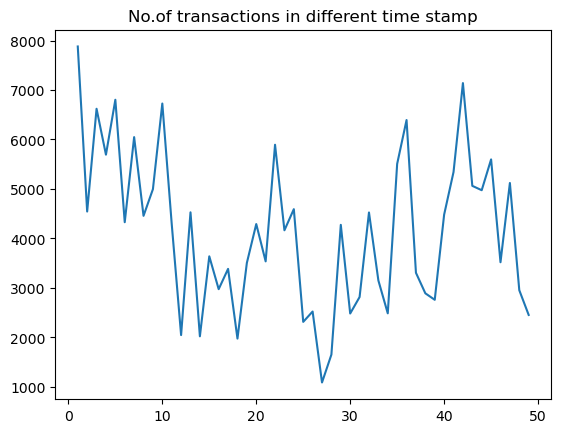

In [21]:
df_features['timestamp'].value_counts().sort_index().plot()
plt.title('No.of transactions in different time stamp')

Let's split the transaction based on the classes

In [22]:
df_merge = pd.merge(df_features,df_classes, left_on = 'txid', right_on = 'txId', how = 'left')
df_merge = df_merge.drop(['txId'],axis = 1)
df_merge.head()

,txid,timestamp,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,aggre_feat_64,aggre_feat_65,aggre_feat_66,aggre_feat_67,aggre_feat_68,aggre_feat_69,aggre_feat_70,aggre_feat_71,aggre_feat_72,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,unknown


In [23]:
df_group = df_merge.groupby(['timestamp','class'])['txid'].count().reset_index().rename(columns = {'txid':'count'})
df_group.head()

,timestamp,class,count
0,1,1,17
1,1,2,2130
2,1,unknown,5733
3,2,1,18
4,2,2,1099


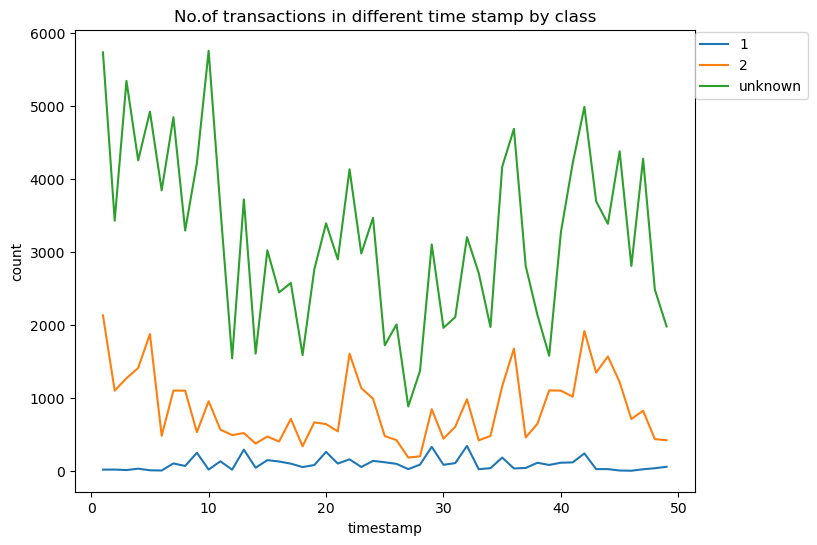

In [24]:
plt.figure(figsize = (8,6))
sns.lineplot(data = df_group , x = 'timestamp',y ='count',hue = 'class')
plt.title('No.of transactions in different time stamp by class')
plt.legend(loc = (1,0.85))
plt.show()

In [25]:
df_merge_missing = df_merge.isna().sum().reset_index().rename(columns = {0:'no.of missing values'})
df_merge_missing.head()

,index,no.of missing values
0,txid,0
1,timestamp,0
2,trans_feat_1,0
3,trans_feat_2,0
4,trans_feat_3,0


In [26]:
df_merge_missing[df_merge_missing['no.of missing values']!=0].count()

index                   0
no.of missing values    0
dtype: int64

There are no missing values present in the merge data

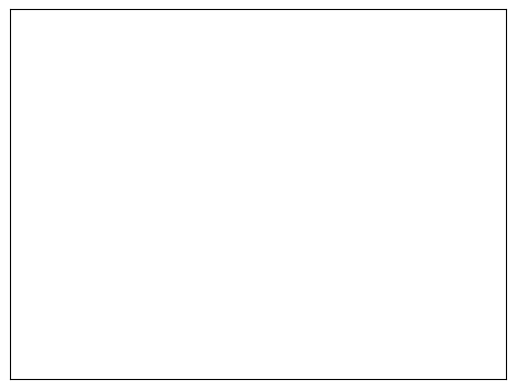

In [184]:
ilicit_ids = df_merge.loc[(df_merge['timestamp'] == 20) & (df_merge['class'] == '1'), 'txid']
ilicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(ilicit_ids)]

graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', )
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True,pos=pos)

In [27]:
df_merge['class'].unique()

array(['unknown', '2', '1'], dtype=object)

<AxesSubplot: title={'center': 'class feature'}>

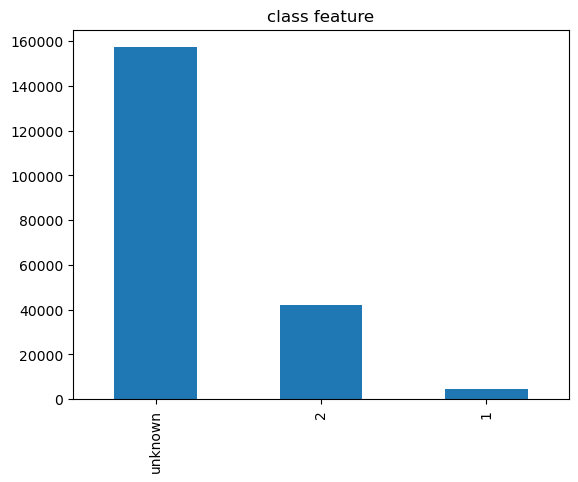

In [28]:
df_merge['class'].value_counts().plot(kind = 'bar', title = 'class feature')

In [29]:
for idx,cal in enumerate(df_merge['class'].unique()):
    print(cal, 'percentage :%.2f' %(df_merge['class'].value_counts()[cal]/df_merge.shape[0]))

unknown percentage :0.77
2 percentage :0.21
1 percentage :0.02


Here , we can observe that 77% of the data is labled and the other 23% of the data is labelled class1 (illicit) and labelled class2 (illicit).So, first we need to perform with labled data.

In [31]:
df_save_labled = df_merge[df_merge['class']!="unknown"]
df_save_labled.head()

,txid,timestamp,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,aggre_feat_64,aggre_feat_65,aggre_feat_66,aggre_feat_67,aggre_feat_68,aggre_feat_69,aggre_feat_70,aggre_feat_71,aggre_feat_72,class
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,2
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,2


In [32]:
df_save_labled.shape

(46564, 168)

In [33]:
df_save_labled.to_csv("labled_data.csv",index = False)

In [118]:
# Converting the categorical feature into numerical feature
df_merge['class'] = df_merge['class'].replace({'unknown':2,'2':0,'1':1})
df_merge.head()

,txid,timestamp,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,aggre_feat_64,aggre_feat_65,aggre_feat_66,aggre_feat_67,aggre_feat_68,aggre_feat_69,aggre_feat_70,aggre_feat_71,aggre_feat_72,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,2
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,2


In [119]:
#labled data
df_labled = df_merge[df_merge['class']!=2]
df_labled.head()

,txid,timestamp,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,aggre_feat_64,aggre_feat_65,aggre_feat_66,aggre_feat_67,aggre_feat_68,aggre_feat_69,aggre_feat_70,aggre_feat_71,aggre_feat_72,class
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


In [120]:
df_labled.shape

(46564, 168)

In [121]:
df_labled['class'].unique()

array([0, 1], dtype=int64)

<AxesSubplot: title={'center': 'labled imbalance data'}>

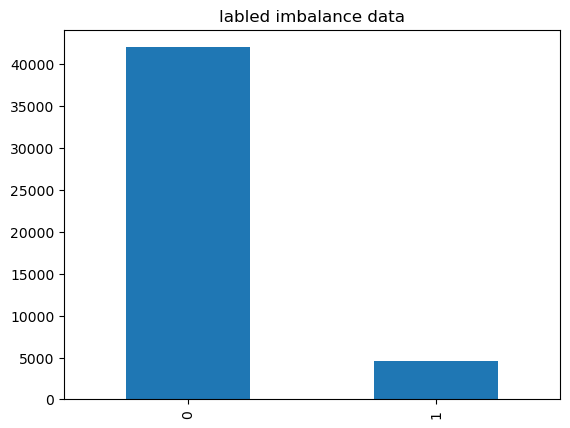

In [122]:
df_labled['class'].value_counts().plot(kind = 'bar',title = 'labled imbalance data')

In [123]:
df_labled['class'].value_counts()

0    42019
1     4545
Name: class, dtype: int64

In [124]:
X = df_labled.drop(['txid','class'],axis =1)
X.head()

,timestamp,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,aggre_feat_63,aggre_feat_64,aggre_feat_65,aggre_feat_66,aggre_feat_67,aggre_feat_68,aggre_feat_69,aggre_feat_70,aggre_feat_71,aggre_feat_72
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [125]:
y = df_labled['class']
y.head()

3     0
9     0
10    0
11    0
16    0
Name: class, dtype: int64

#### Create Functions for model training evaluation

In [126]:
def evaluate_clf(y_true,y_predicted):
    '''
    This function takes y_true and y_predicted values 
    Return: Accuracy,F1-score, Precision, Recall,Roc-auc score
    '''
    acc = accuracy_score(y_true,y_predicted) # calculate accuracy
    f1 = f1_score(y_true,y_predicted) # calculate f1-score
    precision = precision_score(y_true,y_predicted)  # calculate precision
    recall = recall_score(y_true,y_predicted) # calculate recall
    roc_auc = roc_auc_score(y_true,y_predicted) # calculate roc and auc score
    return acc,f1,precision,recall,roc_auc

In [127]:
def total_cost(y_true,y_predicted):
    '''
    This function takes y_true , y_predicted
    Returns: total cost due to missclassification
    '''
    tn,fp,fn,tp = confusion_matrix(y_true,y_predicted).ravel()
    cost = 10*fp + 500*fn
    return cost

In [128]:
def evaluate_models(X,y, models):
    '''
    This function takes in X , and models dictionary as input
    It splits the data into Train Test Split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: DataFrame which contains report of all models with cose
    '''
    # split the data into train and test
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
    
    cost_list = []
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train,y_train) # train the model
        
        # make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)
        
        # training the set performance 
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall, model_train_roauc_score = evaluate_clf(y_train,y_train_pred)
        train_cost = total_cost(y_train,y_train_pred)
        
        # test set performance
        model_test_accuracy, model_test_f1,model_test_precision,\
        model_test_recall, model_test_roauc_score =evaluate_clf(y_test,y_test_pred)
        test_cost = total_cost(y_test,y_test_pred)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        
        print('Model Performance for trainig test')
        print('- Accuracy: {:.4f}' .format(model_train_accuracy))
        print('- F1 score: {:.4f}' .format(model_train_f1))
        print('- Precision: {:.4f}' .format(model_train_precision))
        print('- Recall: {:.4f}' .format(model_train_recall))
        print('- Roc Auc score: {:.4f}' .format(model_train_roauc_score))
        print(f'- COST: {train_cost}.' )
        
        print('-----------------------------------------')
        
        print('Model Performance for test test')
        print('- Accuracy: {:.4f}' .format(model_test_accuracy))
        print('- F1 score: {:.4f}' .format(model_test_f1))
        print('- Precision: {:.4f}' .format(model_test_precision))
        print('- Recall: {:.4f}' .format(model_test_recall))
        print('- Roc Auc score: {:.4f}' .format(model_test_roauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
    report = pd.DataFrame(list(zip(models_list,cost_list)),columns = ['Model Name', 'Cost']).sort_values(by = ['Cost'])
    
    return report  

#### Handling imbalanced data

In [129]:
# resampling the minority class.The strategy can be changed as required
smt = SMOTETomek(random_state = 42,sampling_strategy = 'minority', n_jobs = -1)
# Fit the model to generate the data
X_res,y_res = smt.fit_resample(X,y)

### Intialize Default models in a dictionary 

In [130]:
# Dictionary which contains models for ecperiment
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistice Regression': LogisticRegression(),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'XGBoosting Classifier': XGBClassifier(),
    'CatBoosting Classifier': CatBoostClassifier(verbose = False),
    'AdaBoost Classifier': AdaBoostClassifier()
}

In [131]:
## Training all models
report = evaluate_models(X_res,y_res,models)

Random Forest
Model Performance for trainig test
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc score: 1.0000
- COST: 0.
-----------------------------------------
Model Performance for test test
- Accuracy: 0.9952
- F1 score: 0.9952
- Precision: 0.9987
- Recall: 0.9918
- Roc Auc score: 0.9952
- COST: 34610.


Decision Tree
Model Performance for trainig test
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc score: 1.0000
- COST: 0.
-----------------------------------------
Model Performance for test test
- Accuracy: 0.9839
- F1 score: 0.9840
- Precision: 0.9836
- Recall: 0.9843
- Roc Auc score: 0.9839
- COST: 67380.


Gradient Boosting
Model Performance for trainig test
- Accuracy: 0.9866
- F1 score: 0.9866
- Precision: 0.9912
- Recall: 0.9820
- Roc Auc score: 0.9866
- COST: 305920.
-----------------------------------------
Model Performance for test test
- Accuracy: 0.9850
- F1 score: 0.9850
- Precision: 0.9898
- 

In [134]:
report

,Model Name,Cost
4,K-Neighbors Classifier,11640
5,XGBoosting Classifier,25160
6,CatBoosting Classifier,30620
0,Random Forest,34610
1,Decision Tree,67380
2,Gradient Boosting,84350
7,AdaBoost Classifier,131620
3,Logistice Regression,228730


Based on the performance report, it appears that the XGBoost classifier has a better performance on the test set data compared to the K-Neighbors classifier, with a higher accuracy, F1 score, precision, recall, and ROC AUC score. 
But the XGBoost classifier has a much higher cost (25160) compared to the K-Neighbors classifier (11640).
However, for our use case, we achieve a minmum False Positive Rate in XGBoost Classifier. 
So, the final best model is <b>XGBoost Classifier</b>

### Fitting the Final Model ang get reports

In [136]:
final_model = XGBClassifier()

# Resampling the minority class
smt = SMOTETomek(random_state = 42, sampling_strategy = 'minority',n_jobs=1)
X_res, y_res = smt.fit_resample(X,y)

In [145]:
X_res.shape,y_res.shape

((84038, 166), (84038,))

In [137]:
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res, test_size = 0.2,random_state = 42)

final_model = final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_test)

[16:51:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [138]:
print('Final XGBoost Classifier Accuracy Score (Train) :', final_model.score(X_train,y_train))
print('Final XGBoost Classifier Accuracy Score (Test) :', accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 1.0
Final XGBoost Classifier Accuracy Score (Test) : 0.9960732984293194


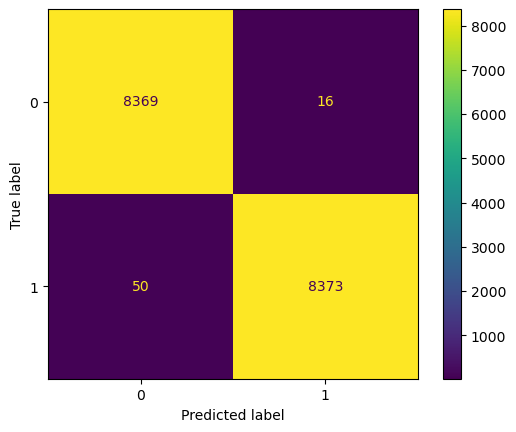

In [144]:
# plots confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels= model.classes_)
disp.plot()
plt.show()

<b>The best Model is XGBoost Classifier with 99.6% accuracy and cost 25160.</b>

In [159]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model,f)

In [165]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
y_pred = pickled_model.predict(X_test.values)

In [174]:
print('Test the model after saving and get the accuracy of : {:.2f}%'.format(accuracy_score(y_pred,y_test)*100))

Test the model after saving and get the accuracy of : 97.48%
